# <center>Fraud Detection System</center>
 <center><b>By</b></center>
 <center><b>Raghav Kumar</b></center>

 
 
### Problem Statement
In this digital era of the payment system, we all do most of our transactions online which made our lives very easy. But do you know every year people lose their money due to online payment fraud and that sums up to billions of dollars?

### Objective
In an attempt to minimize that loss, we want to propose a system that can help banks and payments service providers to analyze the transaction before approving it.

# Dataset :
https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTest.csv

We have used below libararies in our project.

In [2]:
#load packages
from IPython.display import display, HTML
import numpy as np
import sqlite3
import pandas as pd
from sqlite3 import Error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import loadtxt
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree

# 1.Database Creation

## 1.1 Data Understanding

•	The data that we have used captures information of **customer’s transaction details** like, transaction number, transaction date and time, amount, merchant name, category etc. It also consists of **customer’s demographic** information. We have **is_fraud** column in data which **tells whether a particular transaction is tagged as fraud or not.**

•	Data has around **1.3 million records** with **22 columns**.

•	There are **983 unique customers** in the dataset, which has their historical transaction details. These cutomers have spread across **494 different jobs** like mechanical engineer, sales professional, IT etc.

•	There are **700 unique merchants** who belongs to **14 different categories**.



## 1.2 Schema Design

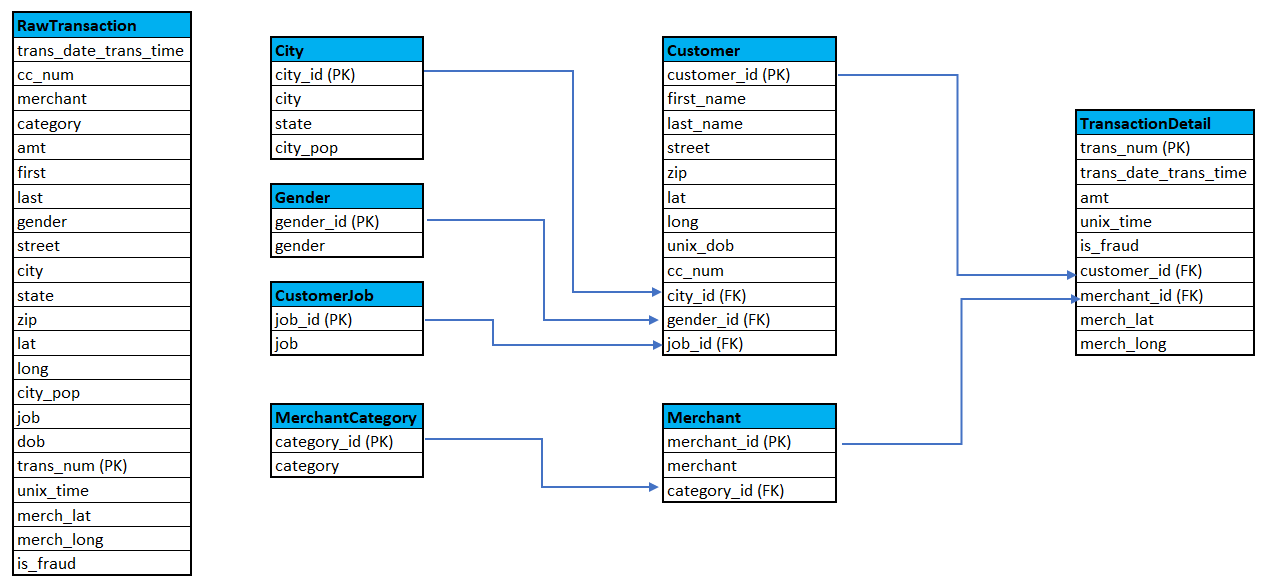

•	We have implemented **snowflake schema** to have all the dimension tables in the normalized form to reduce redundancy.

•	There are **6-dimension tables** and **1-fact table.** We created one more table to store the raw data in the original format.

•	**PK** - Primary Key and **FK** - Foreign Key.

•	All the columns have **not null** constraint.


## 1.3 Table Creation and Data Load

•	We have created 8 different functions for each table creaation and data load to their respective tables.

•	All the data **transformations and data loading** to dimension and fact tables are **happening on server-side through embed SQL queries.**


In [2]:
### Utility Functions
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


In [3]:
# Delete old database file

#close existing connection before deleteling and creating new connection
try:
    conn
except NameError:
    pass
else:
    conn.close()

#database name
database_filename = 'fraud_data.db'

#data_filename
data_filename='fraudData.csv'

#delete and create DB and connection
conn = create_connection(database_filename, delete_db=True)

### Step #1 Create rawtransction table and load

In [4]:
def create_rawtransction_table(data_filename,database_filename):
    
    #list of columns
    list_col = ["trans_date_trans_time", "cc_num","merchant","category","amt","first",
                "last","gender","street","city","state","zip","lat","long","city_pop",
                "job","dob","trans_num","unix_time","merch_lat","merch_long","is_fraud"]
    
    #read unique rows from selected list of columns
    df=pd.read_csv(data_filename, usecols=list_col)
    
    #rename columns as per DB Table
    df.rename(columns = {"first":"first_name","last":"last_name"}, inplace=True)

    
    #create table and load
    create_table_sql= '''CREATE TABLE RawTransaction (
                        trans_date_trans_time DATETIME not null,
                        cc_num Integer not null,
                        merchant Text not null,
                        category Text not null,
                        amt Real not null,
                        first_name Text not null,
                        last_name Text not null,
                        gender Text not null,
                        street Text not null,
                        city Text not null,
                        state Text not null,
                        zip Integer not null,
                        lat Real not null,
                        long Real not null,
                        city_pop Integer not null,
                        job Text not null,
                        dob Date not null,
                        trans_num Text not null,
                        unix_time Integer not null,
                        merch_lat Real not null,
                        merch_long Real not null,
                        is_fraud Integer not null,
                        PRIMARY KEY (trans_num)
                                                );'''
    
    with conn:
        create_table(conn,create_table_sql,drop_table_name='RawTransaction')
        #load to sql
        df.to_sql('RawTransaction', conn, if_exists='append', index = False)

In [5]:
create_rawtransction_table(data_filename,database_filename)
df = pd.read_sql_query("""SELECT * FROM RawTransaction;""", conn)
display(df)

,trans_date_trans_time,cc_num,merchant,category,amt,first_name,last_name,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


### Step #2 Create city table and load

In [6]:
def create_city_table(database_filename):
    
    #create table
    create_table_sql= '''CREATE TABLE City (
                        city_id integer not null,
                        city Text not null,
                        state Text not null,
                        city_pop integer not null,
                        PRIMARY KEY (city_id)
                                                );'''
    
    #insert query
    sql_statement='''INSERT INTO City(city_id,city,state,city_pop)
                        SELECT ROW_NUMBER()  OVER(ORDER BY state asc, city asc) AS city_id
                                ,city
                                ,state
                                ,city_pop
                        FROM RawTransaction
                        GROUP BY city,state
                        
                    ;'''
    
    with conn:
        create_table(conn,create_table_sql,drop_table_name='City')
        
        #insert records
        execute_sql_statement(sql_statement, conn)

    
    

In [7]:
create_city_table(database_filename)
df = pd.read_sql_query("""SELECT * FROM City;""", conn)
display(df)

,city_id,city,state,city_pop
0,1,Huslia,AK,277
1,2,Kaktovik,AK,239
2,3,Wales,AK,145
3,4,Bay Minette,AL,19090
4,5,Bessemer,AL,71463
...,...,...,...,...
923,924,Lonetree,WY,49
924,925,Manville,WY,241
925,926,Riverton,WY,19408
926,927,Rock Springs,WY,27971


### Step #3 Create gender table and load

In [8]:
def create_gender_table(database_filename):
    
    #create table and load
    create_table_sql= '''CREATE TABLE Gender (
                        gender_id integer not null,
                        gender Text not null,
                        PRIMARY KEY (gender_id)
                                                );'''
    
    #insert query
    sql_statement='''INSERT INTO Gender(gender_id,gender)
                        SELECT ROW_NUMBER()  OVER(ORDER BY gender asc) AS gender_id
                                ,gender
                        FROM RawTransaction
                        GROUP BY gender
                        
                    ;'''
    
    with conn:
        create_table(conn,create_table_sql,drop_table_name='Gender')
        
        #insert records
        execute_sql_statement(sql_statement, conn)


In [9]:
create_gender_table(database_filename)
df = pd.read_sql_query("""SELECT * FROM Gender;""", conn)
display(df)

,gender_id,gender
0,1,F
1,2,M


### Step #4 Create customerjob table and load

In [10]:
def create_customerjob_table(data_filename,database_filename):
    
    #create table
    create_table_sql= '''CREATE TABLE CustomerJob (
                        job_id integer not null,
                        job Text not null,
                        PRIMARY KEY (job_id)
                                                );'''
    
    #insert query
    sql_statement='''INSERT INTO CustomerJob(job_id,job)
                        SELECT ROW_NUMBER()  OVER(ORDER BY job asc) AS job_id
                                ,job
                        FROM RawTransaction
                        GROUP BY job
                        
                    ;'''
    
    with conn:
        create_table(conn,create_table_sql,drop_table_name='CustomerJob')
        
        #insert records
        execute_sql_statement(sql_statement, conn)

In [11]:
create_customerjob_table(data_filename,database_filename)
df = pd.read_sql_query("""SELECT * FROM CustomerJob;""", conn)
display(df)

,job_id,job
0,1,Academic librarian
1,2,"Accountant, chartered"
2,3,"Accountant, chartered certified"
3,4,"Accountant, chartered public finance"
4,5,Accounting technician
...,...,...
489,490,Water engineer
490,491,Water quality scientist
491,492,Web designer
492,493,Wellsite geologist


### Step #5 Create merchantcategory table and load

In [12]:
def create_merchantcategory_table(data_filename,database_filename):

    #create table
    create_table_sql= '''CREATE TABLE MerchantCategory (
                        category_id integer not null,
                        category Text not null,
                        PRIMARY KEY (category_id)
                                                );'''
    
    #insert query
    sql_statement='''INSERT INTO MerchantCategory(category_id,category)
                        SELECT ROW_NUMBER()  OVER(ORDER BY category asc) AS category_id
                                ,category
                        FROM RawTransaction
                        GROUP BY category
                        
                    ;'''
    
    with conn:
        create_table(conn,create_table_sql,drop_table_name='MerchantCategory')
        
        #insert records
        execute_sql_statement(sql_statement, conn)

In [13]:
database_filename='fraud_data.db'
create_merchantcategory_table(data_filename,database_filename)
df = pd.read_sql_query("""SELECT * FROM MerchantCategory;""", conn)
display(df)

,category_id,category
0,1,entertainment
1,2,food_dining
2,3,gas_transport
3,4,grocery_net
4,5,grocery_pos
5,6,health_fitness
6,7,home
7,8,kids_pets
8,9,misc_net
9,10,misc_pos


### Step #6 Create merchant table and load

In [14]:
def create_merchant_table(database_filename):
    
    #create table and load
    create_table_sql= '''CREATE TABLE Merchant (
                        merchant_id integer not null,
                        merchant Text not null,
                        category_id integer not null,
                        PRIMARY KEY (merchant_id),
                        FOREIGN KEY (category_id) REFERENCES MerchantCategory(category_id)
                                                );'''
    
    #insert query
    sql_statement='''INSERT INTO Merchant(merchant_id,merchant,category_id)
                        SELECT ROW_NUMBER()  OVER(ORDER BY RT.merchant asc, MC.category_id asc) AS merchant_id
                                ,RT.merchant
                                ,MC.category_id
                        FROM RawTransaction RT 
                        INNER JOIN MerchantCategory MC 
                            ON RT.category=MC.category
                        GROUP BY RT.merchant,MC.category
                        
                    ;'''
    
    with conn:
        create_table(conn,create_table_sql,drop_table_name='Merchant')
        
        #insert records
        execute_sql_statement(sql_statement, conn)

In [15]:
create_merchant_table(database_filename)
df = pd.read_sql_query("""SELECT * FROM Merchant;""", conn)
display(df)

,merchant_id,merchant,category_id
0,1,fraud_Abbott-Rogahn,1
1,2,fraud_Abbott-Steuber,11
2,3,fraud_Abernathy and Sons,2
3,4,fraud_Abshire PLC,1
4,5,"fraud_Adams, Kovacek and Kuhlman",4
...,...,...,...
695,696,fraud_Zemlak Group,9
696,697,"fraud_Zemlak, Tillman and Cremin",11
697,698,fraud_Ziemann-Waters,6
698,699,"fraud_Zieme, Bode and Dooley",3


### Step #7 Create customer table and load

In [16]:
def create_customer_table(database_filename):
    
  #create table
    create_table_sql= '''CREATE TABLE Customer (
                        customer_id integer not null,
                        first_name Text not null,
                        last_name Text not null,
                        street Text not null,
                        zip integer not null,
                        lat Real not null,
                        long Real not null,
                        dob date not null,
                        cc_num integer not null,
                        city_id integer not null,
                        gender_id integer not null,
                        job_id integer not null,
                        PRIMARY KEY (customer_id),
                        FOREIGN KEY (city_id) REFERENCES City(city_id),
                        FOREIGN KEY (gender_id) REFERENCES Gender(gender_id),
                        FOREIGN KEY (job_id) REFERENCES CustomerJob(job_id)
                                                );'''
    
    #insert query
    sql_statement='''INSERT INTO Customer(customer_id,first_name,last_name,street,zip,lat,long,dob,
                                            cc_num,city_id,gender_id,job_id)
                        SELECT ROW_NUMBER()  OVER(ORDER BY RT.first_name asc, RT.last_name asc) AS customer_id
                                ,RT.first_name
                                ,RT.last_name
                                ,RT.street
                                ,RT.zip
                                ,RT.lat
                                ,RT.long
                                ,RT.dob
                                ,RT.cc_num
                                ,C.city_id
                                ,G.gender_id
                                ,CJ.job_id
                        FROM RawTransaction RT 
                        INNER JOIN City C 
                            ON RT.city=C.city AND RT.state=C.state
                        INNER JOIN Gender G 
                            ON RT.gender=G.gender
                        INNER JOIN CustomerJob CJ
                            ON RT.job=CJ.job
                        GROUP BY RT.first_name,RT.last_name,RT.dob,RT.cc_num
                        
                    ;'''
    
    with conn:
        create_table(conn,create_table_sql,drop_table_name='Customer')
        
        #insert records
        execute_sql_statement(sql_statement, conn)
        

In [17]:
create_customer_table(database_filename)
df = pd.read_sql_query("""SELECT * FROM Customer;""", conn)
display(df)

,customer_id,first_name,last_name,street,zip,lat,long,dob,cc_num,city_id,gender_id,job_id
0,1,Aaron,Murray,624 Hale Springs Apt. 572,64659,39.7795,-93.3014,1974-12-23,376028110684021,403,2,474
1,2,Aaron,Pena,793 Hooper Tunnel Suite 154,22015,38.7894,-77.2818,1950-11-27,4958589671582726883,839,2,222
2,3,Aaron,Rogers,969 Huerta Path Apt. 270,69201,42.8062,-100.6215,1945-03-15,4260059589824237,486,2,310
3,4,Aaron,Stewart,400 Zuniga Pine,4364,44.3229,-69.9576,1995-04-22,4228411452607671,334,2,13
4,5,Adam,Keller,32600 Cobb Curve,36775,32.2844,-86.9920,1932-09-17,4917226033950,26,2,264
...,...,...,...,...,...,...,...,...,...,...,...,...
978,979,William,Thompson,977 Rita Grove Apt. 000,12575,41.4575,-74.1659,1937-03-17,4988304376504,583,2,56
979,980,Willie,Jordan,529 West Key,71277,32.9550,-92.5870,1957-08-08,213120463918358,291,2,372
980,981,Xavier,Beltran,61107 Edwards Dam Apt. 463,40914,37.1046,-83.5706,1984-06-04,349612764943496,261,2,372
981,982,Zachary,Allen,69252 Oconnor Alley Apt. 153,52576,41.2001,-92.1354,1969-07-24,213195754007681,180,2,94


### Step #8 Create transactiondetail table and load

In [18]:
def create_transactiondetail_table(database_filename):

    #create table and load
    create_table_sql= '''CREATE TABLE TransactionDetail (
                        trans_num Text not null,
                        trans_date_trans_time DATETIME not null,
                        amt Text Real null,
                        unix_time DATETIME not null,
                        is_fraud integer not null,
                        customer_id integer not null,
                        merchant_id integer not null,
                        merch_lat Real not null,
                        merch_long Real not null,
                        PRIMARY KEY (trans_num),
                        FOREIGN KEY (customer_id) REFERENCES Customer(customer_id),
                        FOREIGN KEY (merchant_id) REFERENCES Merchant(merchant_id)
                                                );'''
    
    #insert query
    sql_statement='''INSERT INTO TransactionDetail(trans_num,trans_date_trans_time,amt,unix_time,is_fraud,
                                            customer_id,merchant_id,merch_lat,merch_long)
                        SELECT   RT.trans_num
                                ,RT.trans_date_trans_time
                                ,RT.amt
                                ,datetime(RT.unix_time, 'unixepoch', 'localtime') as unix_time
                                ,RT.is_fraud
                                ,Cust.customer_id
                                ,M.merchant_id
                                ,RT.merch_lat
                                ,RT.merch_long
                        FROM RawTransaction RT 
                        INNER JOIN Customer Cust 
                            ON RT.first_name=Cust.first_name
                                AND RT.last_name=Cust.last_name
                                AND RT.zip=Cust.zip
                                AND RT.cc_num=Cust.cc_num
                        INNER JOIN Merchant M 
                            ON RT.merchant=M.merchant
                        INNER JOIN MerchantCategory MC
                            ON M.category_id=MC.category_id
                                AND RT.category=MC.category
                        
                    ;'''
    
    with conn:
        create_table(conn,create_table_sql,drop_table_name='TransactionDetail')
        
        #insert records
        execute_sql_statement(sql_statement, conn)
        

In [19]:
create_transactiondetail_table(database_filename)
df = pd.read_sql_query("""SELECT * FROM TransactionDetail;""", conn)
display(df)

,trans_num,trans_date_trans_time,amt,unix_time,is_fraud,customer_id,merchant_id,merch_lat,merch_long
0,dbe29230128b03874e77d7a046e93c28,2019-01-01 14:43:44,74.63,2012-01-01 09:43:44,0,351,1,41.874726,-99.842215
1,525cb6be5e9fa5d6893da177096dfefd,2019-01-01 18:09:49,33.4,2012-01-01 13:09:49,0,26,1,27.341741,-81.701833
2,7c84c6694da8d3fb17d876e8e53cc968,2019-01-01 22:52:02,11.95,2012-01-01 17:52:02,0,960,1,41.658495,-93.860718
3,52a1fe875299ef10ecce0b4d7e3c9adf,2019-01-01 23:26:51,31.06,2012-01-01 18:26:51,0,82,1,40.996279,-85.898931
4,6e0514829a9849d7aa507492fa2f5175,2019-01-01 23:33:56,71.16,2012-01-01 18:33:56,0,825,1,38.438757,-75.542933
...,...,...,...,...,...,...,...,...,...
1296670,832226cc2aaf34fee3272f2df03e6371,2020-06-19 17:58:28,11.8,2013-06-19 13:58:28,0,660,700,41.396335,-74.471305
1296671,d4896dc0b16bc1e1d26a481034652176,2020-06-19 22:57:41,37.24,2013-06-19 18:57:41,0,549,700,38.077003,-100.564281
1296672,7d0b9009bcdd19fcea546cc4ddfb6e79,2020-06-20 15:05:42,18.42,2013-06-20 11:05:42,0,155,700,43.613450,-90.262515
1296673,851a99e5c0f299284130b8a437078357,2020-06-20 18:38:02,13.13,2013-06-20 14:38:02,0,628,700,32.860663,-89.430287


# 2.Analysis
We have created  2 new tables to store test & train data.

In [20]:
# Create Traing and Test data table to fit and test the model.
create_train_table_sql = 'create table TrainData (\
                    trans_num Text PRIMARY KEY NOT NULL,\
                    cc_num integer,\
                    merchant_id integer,\
                    category_id integer,\
                    amt  Real,\
                    gender_id integer,\
                    zip  Integer,\
                    lat  Real,\
                    long  Real,\
                    city_pop integer,\
                    job_id  integer,\
                    dob integer,\
                    unix_time integer,\
                    merch_lat  Real,\
                    merch_long  Real,\
                    tod integer,\
                    age_grp integer,\
                    is_fraud integer\
                    )'
create_test_table_sql ='create table TestData (\
                    trans_num Text PRIMARY KEY NOT NULL,\
                    cc_num integer,\
                    merchant_id integer,\
                    category_id integer,\
                    amt  Real,\
                    gender_id integer,\
                    zip  Integer,\
                    lat  Real,\
                    long  Real,\
                    city_pop integer,\
                    job_id  integer,\
                    dob integer,\
                    unix_time integer,\
                    merch_lat  Real,\
                    merch_long  Real,\
                    tod integer,\
                    age_grp integer,\
                    is_fraud integer,\
                    pred_is_fraud integer\
                    )'


with conn:
    create_table(conn,create_train_table_sql,drop_table_name='TrainData')
    create_table(conn,create_test_table_sql,drop_table_name='TestData')

Based on domain knowledge we fetched reequired columns form different tables and creaded some new features, time of day & age group.

In [21]:
sql_statement='''SELECT   T.trans_num
                                ,Cust.cc_num
                                ,T.merchant_id
                                ,M.category_id
                                ,T.amt
                                ,T.trans_date_trans_time
                                ,Cust.gender_id
                                ,Cust.zip
                                ,Cust.lat
                                ,Cust.long
                                ,C.city_pop
                                ,cust.job_id
                                ,cust.dob
                                ,T.unix_time
                                ,T.merch_lat
                                ,T.merch_long
                                ,T.is_fraud
                        FROM TransactionDetail T 
                        INNER JOIN Customer Cust 
                            ON T.customer_id=Cust.customer_id
                        INNER JOIN Merchant M 
                            ON T.merchant_id=M.merchant_id
                        INNER JOIN City C
                            ON C.City_id=Cust.City_id
                    ;'''
df = pd.read_sql_query(sql_statement, conn)
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['tod'] = pd.cut(df.trans_date_trans_time.dt.hour,bins=[-1,4,8,12,16,20,24],labels=[0,1,2,3,4,5])
df['age_grp'] = pd.cut((df.trans_date_trans_time.dt.year-df.dob.dt.year),bins=[0,18,35,55,100],labels=[0,1,2,3])
df

,trans_num,cc_num,merchant_id,category_id,amt,trans_date_trans_time,gender_id,zip,lat,long,city_pop,job_id,dob,unix_time,merch_lat,merch_long,is_fraud,tod,age_grp
0,dbe29230128b03874e77d7a046e93c28,4666314527820883145,1,1,74.63,2019-01-01 14:43:44,2,68869,41.0233,-98.9041,2202,428,1974-06-21,2012-01-01 09:43:44,41.874726,-99.842215,0,3,2
1,525cb6be5e9fa5d6893da177096dfefd,30044330818990,1,1,33.4,2019-01-01 18:09:49,1,33967,26.4722,-81.8122,224256,328,1985-08-29,2012-01-01 13:09:49,27.341741,-81.701833,0,4,1
2,7c84c6694da8d3fb17d876e8e53cc968,4623560839669,1,1,11.95,2019-01-01 22:52:02,2,51453,42.2619,-94.5566,695,7,1954-07-15,2012-01-01 17:52:02,41.658495,-93.860718,0,5,3
3,52a1fe875299ef10ecce0b4d7e3c9adf,560881134780,1,1,31.06,2019-01-01 23:26:51,1,46946,41.0356,-85.7358,136,426,1953-03-19,2012-01-01 18:26:51,40.996279,-85.898931,0,5,3
4,6e0514829a9849d7aa507492fa2f5175,4446368897795790,1,1,71.16,2019-01-01 23:33:56,2,23303,37.9073,-75.5089,741,213,1986-08-17,2012-01-01 18:33:56,38.438757,-75.542933,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,832226cc2aaf34fee3272f2df03e6371,180048185037117,700,11,11.8,2020-06-19 17:58:28,1,7060,40.6152,-74.4150,71485,269,1974-07-19,2013-06-19 13:58:28,41.396335,-74.471305,0,4,2
1296671,d4896dc0b16bc1e1d26a481034652176,30074693890476,700,11,37.24,2020-06-19 22:57:41,1,67851,37.9931,-100.9893,2691,30,1993-08-16,2013-06-19 18:57:41,38.077003,-100.564281,0,5,1
1296672,7d0b9009bcdd19fcea546cc4ddfb6e79,5388659976630693,700,11,18.42,2020-06-20 15:05:42,2,54654,43.2064,-90.9405,153,382,1962-02-14,2013-06-20 11:05:42,43.613450,-90.262515,0,3,3
1296673,851a99e5c0f299284130b8a437078357,213141712584544,700,11,13.13,2020-06-20 18:38:02,1,39073,32.1530,-90.1217,19685,197,1984-12-24,2013-06-20 14:38:02,32.860663,-89.430287,0,4,2


Fortunately we don't have any null or NaN values in our dataset.

In [22]:
df.isnull().sum()

trans_num                0
cc_num                   0
merchant_id              0
category_id              0
amt                      0
trans_date_trans_time    0
gender_id                0
zip                      0
lat                      0
long                     0
city_pop                 0
job_id                   0
dob                      0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
tod                      0
age_grp                  0
dtype: int64

In [23]:
#Split Data into train and test.
train, test = train_test_split(df, test_size=0.1, random_state = 1)
#Load train and test data in db tables.
train.to_sql('TrainData', conn, if_exists='replace', index = False)
test.to_sql('TestData', conn, if_exists='replace', index = False)

In [24]:
df_vis = pd.read_sql_query("""SELECT t.cc_num,t.zip,t.category_id,age_grp,tod,merchant,amt,city_pop,
                            t.job_id, t.merchant_id, category,job, is_fraud FROM TrainData t
                            inner join MerchantCategory cat ON t.category_id=cat.category_id 
                            inner join Merchant m ON m.merchant_id = t.merchant_id
                            inner join CustomerJob j on j.job_id = t.job_id""", conn)
df_vis

,cc_num,zip,category_id,age_grp,tod,merchant,amt,city_pop,job_id,merchant_id,category,job,is_fraud
0,2288813824604479,10039,4,2,0,"fraud_Kohler, Lindgren and Koelpin",49.17,1577385,223,336,grocery_net,Herbalist,0
1,4635330563105903,22046,1,2,4,"fraud_Hoppe, Harris and Bednar",80.11,116155,69,268,entertainment,Chartered accountant,0
2,3541160328600277,62668,1,0,4,"fraud_Runolfsdottir, Mueller and Hand",98.99,1512,95,545,entertainment,Commercial/residential surveyor,0
3,2286236465059468,64726,3,3,2,fraud_Luettgen PLC,59.35,467,17,406,gas_transport,Agricultural consultant,0
4,4208110975550360171,31567,8,2,3,"fraud_Lowe, Dietrich and Erdman",47.06,782,43,403,kids_pets,Audiological scientist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167002,4464457352619,32323,7,1,5,fraud_Eichmann-Kilback,20.09,217,460,159,home,Television production assistant,0
1167003,36485887555770,43321,13,0,4,fraud_Lesch Ltd,147.41,267,190,394,shopping_pos,Facilities manager,0
1167004,180084576295055,77971,12,2,0,"fraud_Romaguera, Cruickshank and Greenholt",2.18,911,31,535,shopping_net,Archaeologist,0
1167005,4155021259183870,73559,10,2,4,fraud_Gislason Group,28.19,540,393,195,misc_pos,Research scientist (life sciences),0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


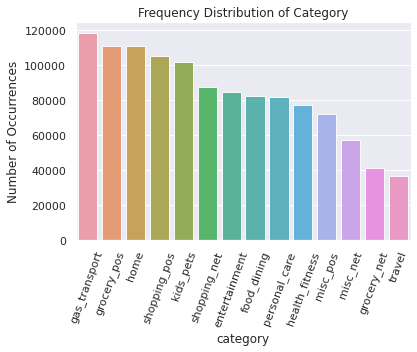

In [25]:
cat_count = df_vis['category'].value_counts()
sns.set(style="darkgrid")
sns.barplot(cat_count.index, cat_count.values, alpha=0.9)
plt.title('Frequency Distribution of Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.xticks(rotation=70)
plt.show()

<AxesSubplot:xlabel='is_fraud', ylabel='merchant_id'>

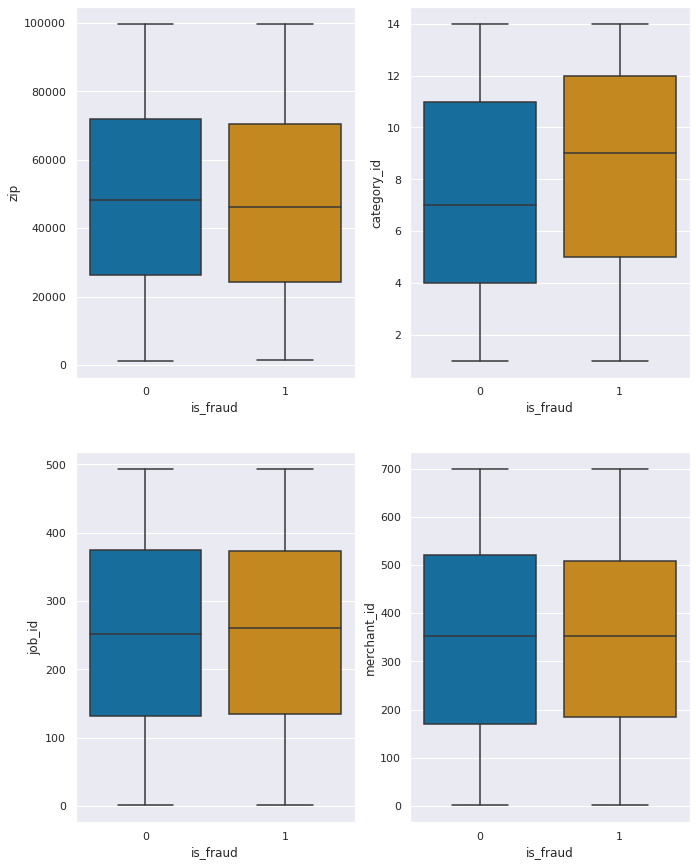

In [26]:
fig,ar = plt.subplots(nrows=2,ncols=2,figsize=(11,15))
sns.boxplot(x='is_fraud',y='zip', 
                 data=df_vis, 
                 palette="colorblind",
                 ax=ar[0,0]
                 )

sns.boxplot(x='is_fraud',y='category_id', 
                 data=df_vis, 
                 palette="colorblind",
                ax=ar[0,1]
                 )

sns.boxplot(x='is_fraud',y='job_id', 
                 data=df_vis, 
                 palette="colorblind",
                 ax=ar[1,0]
                 )

sns.boxplot(x='is_fraud',y='merchant_id', 
                 data=df_vis, 
                 palette="colorblind",
                 ax=ar[1,1]
                 )

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


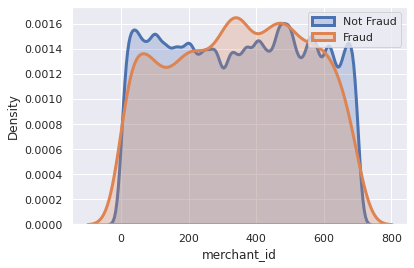

In [27]:
x1 = df_vis.loc[df_vis['is_fraud'] == 1, 'merchant_id']
x0 = df_vis.loc[df_vis['is_fraud'] == 0, 'merchant_id']

Repay = ['Not Fraud','Fraud']
sns.distplot(x0, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Not Fraud')
sns.distplot(x1, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Fraud')
plt.legend()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


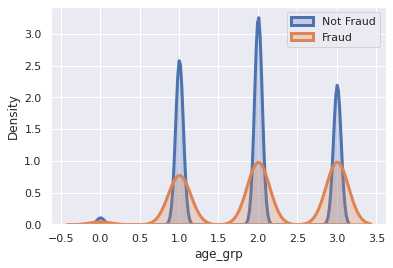

In [28]:
x1 = df_vis.loc[df_vis['is_fraud'] == 1, 'age_grp']
x0 = df_vis.loc[df_vis['is_fraud'] == 0, 'age_grp']

Repay = ['Not Fraud','Fraud']
sns.distplot(x0, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Not Fraud')
sns.distplot(x1, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Fraud')
plt.legend()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


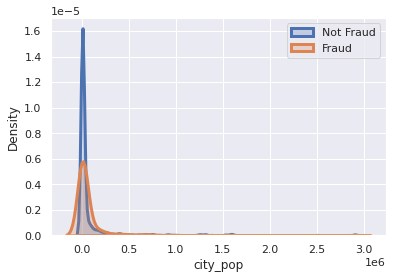

In [29]:
x1 = df_vis.loc[df_vis['is_fraud'] == 1, 'city_pop']
x0 = df_vis.loc[df_vis['is_fraud'] == 0, 'city_pop']

Repay = ['Not Fraud','Fraud']
sns.distplot(x0, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Not Fraud')
sns.distplot(x1, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},label='Fraud')
plt.legend()

We used corelation matrix and heat plot to select relivent features.

In [30]:
df_corr = train.drop('trans_num',axis=1)
df_corr[["tod", "age_grp"]] = df_corr[["tod", "age_grp"]].apply(pd.to_numeric)
df_corr.corr()

,cc_num,merchant_id,category_id,gender_id,zip,lat,long,city_pop,job_id,merch_lat,merch_long,is_fraud,tod,age_grp
cc_num,1.000000,0.000265,0.001515,0.001006,0.041233,-0.058700,-0.048331,-0.009205,0.029426,-0.058361,-0.048311,-0.000556,-0.001044,-0.005842
merchant_id,0.000265,1.000000,0.032215,-0.000783,0.001111,-0.002215,-0.000827,0.001942,0.001358,-0.002210,-0.000803,-0.000474,-0.002647,-0.006251
category_id,0.001515,0.032215,1.000000,-0.028244,0.002189,-0.008505,-0.000573,0.009777,0.003588,-0.008388,-0.000558,0.019649,0.156958,-0.004786
gender_id,0.001006,-0.000783,-0.028244,1.000000,-0.066209,0.042673,0.050625,-0.028919,-0.079770,0.042353,0.050573,0.007819,-0.037754,0.014438
zip,0.041233,0.001111,0.002189,-0.066209,1.000000,-0.114622,-0.909809,0.079042,-0.005862,-0.113867,-0.909001,-0.002368,0.005308,0.008073
lat,-0.058700,-0.002215,-0.008505,0.042673,-0.114622,1.000000,-0.014525,-0.156259,-0.027156,0.993588,-0.014498,0.001918,-0.011325,0.054803
long,-0.048331,-0.000827,-0.000573,0.050625,-0.909809,-0.014525,1.000000,-0.053101,-0.002722,-0.014479,0.999120,0.002018,-0.001710,-0.027125
city_pop,-0.009205,0.001942,0.009777,-0.028919,0.079042,-0.156259,-0.053101,1.000000,-0.055454,-0.155303,-0.053069,0.002358,0.019971,-0.065247
job_id,0.029426,0.001358,0.003588,-0.079770,-0.005862,-0.027156,-0.002722,-0.055454,1.000000,-0.027004,-0.002732,0.000083,0.011327,-0.034216
merch_lat,-0.058361,-0.002210,-0.008388,0.042353,-0.113867,0.993588,-0.014479,-0.155303,-0.027004,1.000000,-0.014455,0.001754,-0.011170,0.054379


<AxesSubplot:>

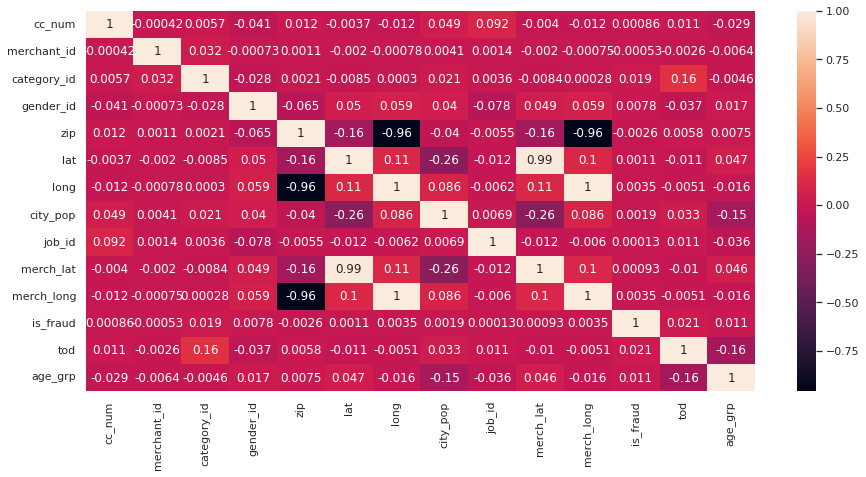

In [31]:
plt.figure(figsize=(15,7))
sns.heatmap((df_corr[:]).corr(method="spearman"),annot=True)

Selected features using corelation matrix and heatmap.

In [32]:
#Fetch X_train, y_train, X_test & y_test from the table.
X_train = pd.read_sql_query("""SELECT zip,category_id,age_grp,tod,gender_id FROM TrainData""", conn)
y_train = pd.read_sql_query("""SELECT is_fraud FROM TrainData""", conn)
X_test = pd.read_sql_query("""SELECT zip,category_id, age_grp,tod,gender_id FROM TestData""", conn)
y_test = pd.read_sql_query("""SELECT is_fraud FROM TestData""", conn)
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


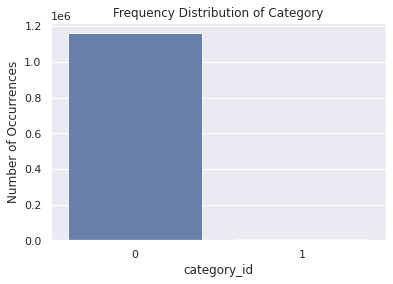

In [33]:
cat_count = y_train['is_fraud'].value_counts()
sns.set(style="darkgrid")
sns.barplot(cat_count.index, cat_count.values, alpha=0.9)
plt.title('Frequency Distribution of Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category_id', fontsize=12)
plt.show()

# Implemented Neural Network

In [34]:
# Train Deep learning model.
relu = 'relu'
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16, activation=relu, input_shape=[X_train.shape[1]]),
    layers.Dense(16, activation=relu),
    layers.Dense(16, activation=relu),
    layers.Dense(16, activation=relu),
    layers.Dense(16, activation=relu),
    layers.Dense(16, activation=relu),
    layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-12-11 09:26:28.269628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-11 09:26:28.269669: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-11 09:26:28.269687: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eas503.ccr.buffalo.edu): /proc/driver/nvidia/version does not exist
2021-12-11 09:26:28.269905: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
model.fit(X_train, y_train, epochs=10, batch_size=100000)
_, accuracy = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
12/12 [==============================] - 1s 16ms/step - loss: 353.0366 - accuracy: 0.3166
Epoch 2/10
12/12 [==============================] - 0s 12ms/step - loss: 2.1617 - accuracy: 0.9942
Epoch 3/10
12/12 [==============================] - 0s 11ms/step - loss: 2.8320 - accuracy: 0.9942
Epoch 4/10
12/12 [==============================] - 0s 12ms/step - loss: 2.9142 - accuracy: 0.9942
Epoch 5/10
12/12 [==============================] - 0s 12ms/step - loss: 2.8740 - accuracy: 0.9942
Epoch 6/10
12/12 [==============================] - 0s 11ms/step - loss: 2.7916 - accuracy: 0.9942
Epoch 7/10
12/12 [==============================] - 0s 13ms/step - loss: 2.6890 - accuracy: 0.9942
Epoch 8/10
12/12 [==============================] - 0s 11ms/step - loss: 2.5697 - accuracy: 0.9942
Epoch 9/10
12/12 [==============================] - 0s 11ms/step - loss: 2.4404 - accuracy: 0.9942
Epoch 10/10
12/12 [==============================] - 0s 11ms/step - loss: 2.3070 - accuracy: 0.9942
Accurac

In [36]:
# Determine confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred.astype(int)))
print(accuracy_score(y_test, y_pred))

[[128898      0]
 [   770      0]]
0.994061757719715


Tries Under Sampling

In [37]:
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
X_test_under, y_test_under = undersample.fit_resample(X_test, y_test)

In [38]:
model.fit(X_train_under, y_train_under, epochs=60, batch_size=500)
_, accuracy = model.evaluate(X_train_under, y_train_under, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/60
27/27 [==============================] - 0s 1ms/step - loss: 57.0482 - accuracy: 0.5016
Epoch 2/60
27/27 [==============================] - 0s 1ms/step - loss: 3.6646 - accuracy: 0.5007
Epoch 3/60
27/27 [==============================] - 0s 1ms/step - loss: 2.9159 - accuracy: 0.5097
Epoch 4/60
27/27 [==============================] - 0s 1ms/step - loss: 2.0511 - accuracy: 0.4935
Epoch 5/60
27/27 [==============================] - 0s 1ms/step - loss: 1.0783 - accuracy: 0.4993
Epoch 6/60
27/27 [==============================] - 0s 1ms/step - loss: 1.0449 - accuracy: 0.4989
Epoch 7/60
27/27 [==============================] - 0s 1ms/step - loss: 0.7694 - accuracy: 0.4901
Epoch 8/60
27/27 [==============================] - 0s 1ms/step - loss: 0.7499 - accuracy: 0.4968
Epoch 9/60
27/27 [==============================] - 0s 1ms/step - loss: 0.7498 - accuracy: 0.5016
Epoch 10/60
27/27 [==============================] - 0s 1ms/step - loss: 0.7734 - accuracy: 0.4931
Epoch 11/60
27/27 

In [39]:
y_pred = (model.predict(X_test_under) > 0.5).astype(int)
print(confusion_matrix(y_test_under, y_pred.astype(int)))
print(accuracy_score(y_test_under, y_pred))

[[405 365]
 [292 478]]
0.5733766233766234


Tries Over Sampling

In [40]:
X_train_over, y_train_over = SMOTE().fit_resample(X_train, y_train)
X_test_over, y_test_over = SMOTE().fit_resample(X_test, y_test)

In [41]:
model.fit(X_train_over, y_train_over, epochs=10, batch_size=50000)
_, accuracy = model.evaluate(X_train_over, y_train_over, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
47/47 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.5259
Epoch 2/10
47/47 [==============================] - 0s 7ms/step - loss: 0.6861 - accuracy: 0.5371
Epoch 3/10
47/47 [==============================] - 0s 7ms/step - loss: 0.6863 - accuracy: 0.5378
Epoch 4/10
47/47 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5331
Epoch 5/10
47/47 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5258
Epoch 6/10
47/47 [==============================] - 0s 7ms/step - loss: 0.6888 - accuracy: 0.5268
Epoch 7/10
47/47 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5356
Epoch 8/10
47/47 [==============================] - 0s 6ms/step - loss: 0.6874 - accuracy: 0.5386
Epoch 9/10
47/47 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5261
Epoch 10/10
47/47 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5268
Accuracy: 54.43


In [42]:
y_pred = (model.predict(X_test_over) > 0.5).astype(int)
print(confusion_matrix(y_test_over, y_pred.astype(int)))
print(accuracy_score(y_test_over, y_pred))

[[105751  23147]
 [ 97014  31884]]
0.5338911387298484


Since the results are not promising from Neural Networks we tried Decision Tree

# Decision Tree

In [43]:
mdl = tree.DecisionTreeClassifier().fit(X_train,y_train)
pred = mdl.predict(X_test)
print(confusion_matrix(y_test, pred.astype(int)))
print(accuracy_score(y_test, pred.astype(int)))

[[128892      6]
 [   455    315]]
0.9964447666347904


Tried Over Sampling

In [44]:
mdl = tree.DecisionTreeClassifier().fit(X_train_over,y_train_over)
pred = mdl.predict(X_test_over)
print(confusion_matrix(y_test_over, pred.astype(int)))
print(accuracy_score(y_test_over, pred.astype(int)))

[[126454   2444]
 [  2991 125907]]
0.9789174385948579


We are getting good accuracy, sensitivity and specificity using Decision tree on over sampled data.

# Results & Future Improvements
<ul>
    <li>By using <b>Decision Tree</b> on over-sampled data we are getting <b>97.89% accuracy</b> and <b> 0.98 sensitivity</b>. </li>
  <li>We can get accurate results with balanced data.</li>
  <li>If we could have data related to transactions like <b>Card Present Indicator, POS Terminal Mode, Transaction Type, etc</b>.</li>
</ul> 